In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def preprocess_train_data(train_data_path): # include type hints later and 
    # clean up the return from docstring
    """
    Split train data into features and target
    csv file specified in path is read as pandas df.
    The columns are renamed. 
    
    Arguments
    _________
    train_data_path : system path for training csv file
    
    Returns
    _______
    Pandas dataframe
    """
    
    stores_sales = pd.read_csv(train_data_path)

    # rename target column to business for intuition. Increase the business.
    stores_sales.rename(columns={'Item_Outlet_Sales':'business'}, inplace=True)

    # parse target(buisness) and features(situations) for intuition
    situations = stores_sales.drop(columns=['business'])
    business = stores_sales['business']

    return situations, business

In [3]:
def get_cat_feature_names(situations):
    """
    Gives the list of categorical column names

    Returns
    _______
    list of names
    """
    # store column data types as pandas series
    columns_types = situations.dtypes

    # filter the series for object datatype using object string and get index. 
    # Then convert index to array
    return columns_types[columns_types == 'object'].index.values

In [4]:
def get_num_feature_names(situations):
    """
    Gives the list of numerical column names

    Returns
    _______
    list of names
    """
    # store column data types as pandas series
    columns_types = situations.dtypes

    # filter the series for object datatype using object string and get index. 
    # Then convert index to array
    return columns_types[columns_types != 'object'].index.values

In [5]:
def encode_cat_cols(situations, cat_cols_encoder_types):
    """
    Encodes categroical columns in situations.

    2. Stores the encoders in a dict against each column name. The column encoder is 
    retrieved for a col name and fit/trained on that column data in situations. Then, the  
    column is then encoded in situations. (Do I need to store the encoder? 
    Will it be used later on? What about the encoding of future dataset?)

    3. The new encoded columns are added to situations with new names.
    The encoded name to original name dict is maintained. It is returned for future use.
    
    Returns
    _______
    situations df with encoded columns
    enc_col_names_to_col_names_dict
    
    """

    # col encoders dictionary will store the encoders for each colum
    col_encoders_dict = {}

    # enc_col_names_to_col_names_dict will store the encoded column name
    # to original column name mapping 
    enc_col_names_to_col_names_dict = {}

    # Pick up cat column from cat_cols_encoder_types one at a time
    for col, encoder_type in cat_cols_encoder_types.items():
        encoded_col_name = f"{col}_encoded"

        # storing mapping from encoded columns 
        # to original columns
        enc_col_names_to_col_names_dict[encoded_col_name] = col

        # Creating encoder for each column and storing in dict
        if encoder_type == 'label':
            col_encoders_dict[col] = LabelEncoder()
            # fitting the encoders on cat column of situation and
            # encoding the columns in situations
            situations[encoded_col_name] = col_encoders_dict[col].fit_transform(situations[col])
        else:
            col_encoders_dict[col] = OneHotEncoder(sparse_output=False)
            # fitting the encoders on cat column of situation and
            # encoding the columns in situations
            encoded_array = col_encoders_dict[col].fit_transform(situations[[col]])
            # Add the one-hot encoded columns to the DataFrame
            for i, category in enumerate(col_encoders_dict[col].categories_[0]):
                situations[f"{encoded_col_name}_{category}"] = encoded_array[:, i]

    return situations, col_encoders_dict

In [6]:
def get_unique_cat_values_from_situations(situations):
    situations_cat_cols_names = get_cat_feature_names(situations)
    situations_cat_cols_values = {}

    for cat_col in situations_cat_cols_names:
        # get one column of the situation
        # store the unique values in a dict
        situations_cat_cols_values[cat_col] = situations[cat_col].unique()
        # return the dict to visualise it

    return situations_cat_cols_values

In [7]:
def clean_cat_columns(situations):
    """
    standardise the categories within catgeorical columns.
    Removes duplicate categories

    Returns
    _______
    df with categories cleaned
    """
    # replace 'Low Fat' 'low fat' with LF in Item_Fat_Content
    situations.loc[(situations['Item_Fat_Content'] == 'Low Fat')\
                    | (situations['Item_Fat_Content'] == 'low fat'),\
                    'Item_Fat_Content'] = 'LF'
    
    # replace 'Low Fat' 'low fat' with LF in Item_Fat_Content
    situations.loc[situations['Item_Fat_Content'] == 'Regular','Item_Fat_Content'] = 'reg'    

    return situations

## Cleaning

In [8]:
train_data_path = r'/Users/yadav.a.1/Downloads/train_v9rqX0R.csv'
situations, business  = preprocess_train_data(train_data_path=train_data_path)
num_of_rows_situations = len(situations) # use this in .iloc[num_of_rows_situations:] to get stores_assortments back

stores_assortments    = pd.read_csv(r'/Users/yadav.a.1/Downloads/test_AbJTz2l.csv')
num_of_rows_assortments = len(stores_assortments) # use later for checking the number of rows after splititng

In [9]:
np.array(situations.shape) + np.array(stores_assortments.shape)

array([14204,    22])

In [10]:
situations = pd.concat([stores_assortments, situations], axis=0, ignore_index=True)
np.array(situations.shape)

array([14204,    11])

### Clean up categorical columns. 
First See the values

In [11]:
situations_cat_cols_values_dict = get_unique_cat_values_from_situations(situations)
for col in situations_cat_cols_values_dict:
    print("\n", col, "\n", situations_cat_cols_values_dict[col])


 Item_Identifier 
 ['FDW58' 'FDW14' 'NCN55' ... 'FDL10' 'FDX04' 'FDU19']

 Item_Fat_Content 
 ['Low Fat' 'reg' 'Regular' 'LF' 'low fat']

 Item_Type 
 ['Snack Foods' 'Dairy' 'Others' 'Fruits and Vegetables' 'Baking Goods'
 'Health and Hygiene' 'Breads' 'Hard Drinks' 'Seafood' 'Soft Drinks'
 'Household' 'Frozen Foods' 'Meat' 'Canned' 'Starchy Foods' 'Breakfast']

 Outlet_Identifier 
 ['OUT049' 'OUT017' 'OUT010' 'OUT027' 'OUT046' 'OUT018' 'OUT045' 'OUT019'
 'OUT013' 'OUT035']

 Outlet_Size 
 ['Medium' nan 'Small' 'High']

 Outlet_Location_Type 
 ['Tier 1' 'Tier 2' 'Tier 3']

 Outlet_Type 
 ['Supermarket Type1' 'Grocery Store' 'Supermarket Type3'
 'Supermarket Type2']


standardise categoriies to remove duplicates
Item_Fat_Content : combine 'Low Fat' 'low fat' 'LF' and 'Regular''reg'

In [12]:
situations = clean_cat_columns(situations)
print("\n", situations['Item_Fat_Content'].unique())


 ['LF' 'reg']


### Cleaning up numerical columns
'Item_Weight' 'Item_Visibility' 'Item_MRP' 'Outlet_Establishment_Year'

In [13]:
num_cols = get_num_feature_names(situations)
print(num_cols)

['Item_Weight' 'Item_Visibility' 'Item_MRP' 'Outlet_Establishment_Year']


1. boxplot will show us outliers
2. Histogram will show us garbage values
3. print unique values of year

Outlet_Establishment_Year

In [14]:
print(sorted(situations['Outlet_Establishment_Year'].unique()))

[1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009]


<BarContainer object of 9 artists>

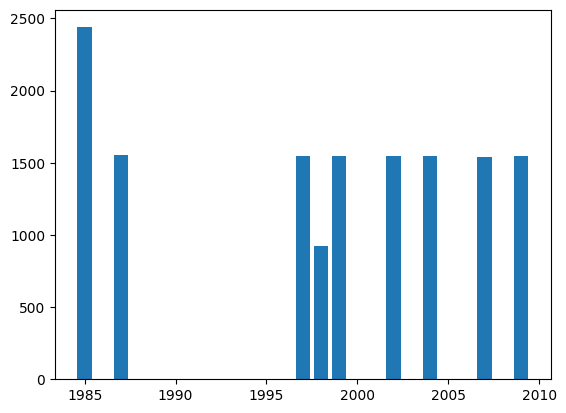

In [15]:
year_value_counts = situations['Outlet_Establishment_Year'].value_counts()
plt.bar(year_value_counts.index, year_value_counts.values)

Item_Weight
histogram

(array([ 820., 1496., 1440., 1176., 1244., 1022., 1275., 1189., 1094.,
        1009.]),
 array([ 4.555 ,  6.2345,  7.914 ,  9.5935, 11.273 , 12.9525, 14.632 ,
        16.3115, 17.991 , 19.6705, 21.35  ]),
 <BarContainer object of 10 artists>)

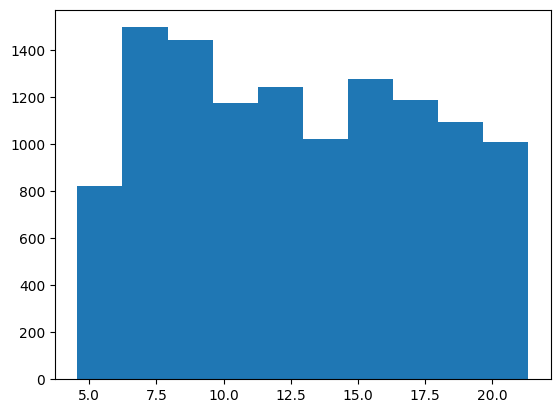

In [16]:
plt.hist(situations['Item_Weight'])

Item_Visibility
1. hist, boxplot

(array([4390., 3918., 2611., 1650.,  939.,  447.,  105.,   65.,   50.,
          29.]),
 array([0.        , 0.03283909, 0.06567819, 0.09851728, 0.13135638,
        0.16419547, 0.19703457, 0.22987366, 0.26271276, 0.29555185,
        0.32839095]),
 <BarContainer object of 10 artists>)

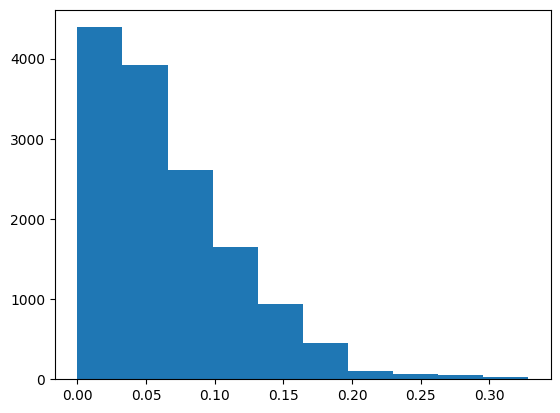

In [17]:
plt.hist(situations['Item_Visibility'])

{'whiskers': [<matplotlib.lines.Line2D at 0x16b79a980>,
 'caps': [<matplotlib.lines.Line2D at 0x16b79af80>,
 'boxes': [<matplotlib.lines.Line2D at 0x16b79a680>],
 'medians': [<matplotlib.lines.Line2D at 0x16b79b580>],
 'fliers': [<matplotlib.lines.Line2D at 0x16b79b880>],
 'means': []}

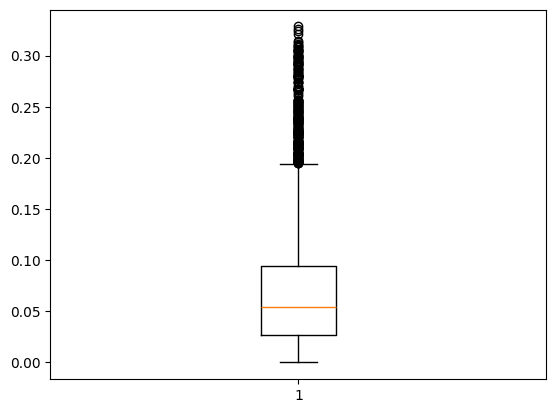

In [18]:
plt.boxplot(situations['Item_Visibility'])

Item_MRP

(array([1519.,  953., 1745., 2140., 1322., 1816., 2009.,  783.,  966.,
         951.]),
 array([ 31.29   ,  54.84984,  78.40968, 101.96952, 125.52936, 149.0892 ,
        172.64904, 196.20888, 219.76872, 243.32856, 266.8884 ]),
 <BarContainer object of 10 artists>)

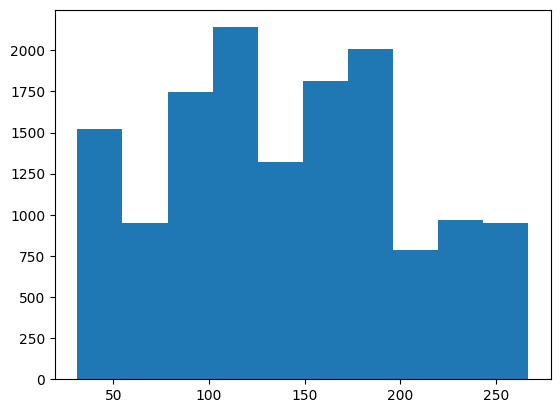

In [19]:
plt.hist(situations['Item_MRP'])

{'whiskers': [<matplotlib.lines.Line2D at 0x16b89de70>,
 'caps': [<matplotlib.lines.Line2D at 0x16b89e470>,
 'boxes': [<matplotlib.lines.Line2D at 0x16b89c9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x16b89ea70>],
 'fliers': [<matplotlib.lines.Line2D at 0x16b89ed70>],
 'means': []}

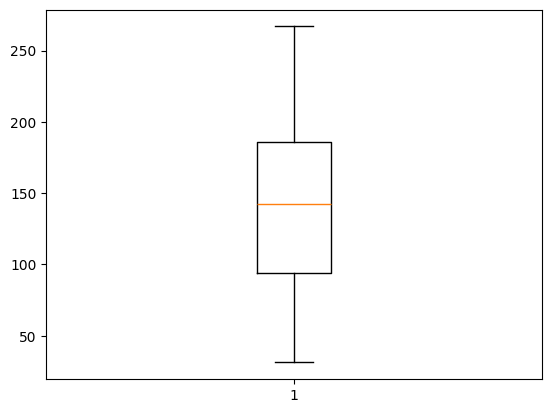

In [20]:
plt.boxplot(situations['Item_MRP'])

## Missing Values

In [21]:
situations.isna().sum() * 100 / len(situations)

Item_Identifier               0.000000
Item_Weight                  17.171219
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.273726
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64

Fill missing values in Item_Weight

 1. We'll normalize the numerical columns like Item_Visibility and Item_MRP. Finally, we'll apply k-NN imputation. Ww will also use one hot encoded Item_Identifier_encoded, and Item_Type_encoded and label encoded Item_Fat_Content_encoded to estimate the missing values in Item_Weight, experimenting with different values of k to find the best fit.

 2. Use itme identifier to fill in weight. Yes, that's exactly right. You'll create a dictionary mapping item identifiers to their weights, then use that dictionary to fill in the missing weights based on the item identifier. It's a straightforward and efficient way to handle the missing data in this case.

In [22]:
# create dict with item identifiers as keys and real weights as values
# get item identifers with non missing weights
weights_df = situations[~situations['Item_Weight'].isna()][['Item_Identifier', 'Item_Weight']].drop_duplicates()
weights_dict = weights_df.set_index('Item_Identifier')['Item_Weight'].to_dict()

# create a list of item identifiers with missing weights.
missing_weights_items = situations[situations['Item_Weight'].isna()]['Item_Identifier'].drop_duplicates()

print(len(missing_weights_items), len(weights_dict))

# check if they have weights in the dict
found_items = set(missing_weights_items).intersection(set(weights_dict))
print(len(found_items))

1559 1559
1559


fill the 1138 item weights and just fill the category mean for the reamining 4.
The fillna method will just look up those IDs in the dict that are missing the weights. Then it will map the corrsponign weight from the dict 


In [23]:
def fill_missing_item_weight(situations, weights_dict):
    situations['Item_Weight'].fillna(situations['Item_Identifier'].map(weights_dict), inplace=True)
    situations['Item_Weight'].fillna(situations['Item_Weight'].mean(), inplace=True)

    return situations

In [24]:
situations = fill_missing_item_weight(situations, weights_dict) 
situations.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

Fill missing values in Outlet_Size

In [25]:
# create dict with item identifiers as keys and real weights as values
# get item identifers with non missing weights
weights_df = situations[~situations['Outlet_Size'].isna()][['Outlet_Identifier', 'Outlet_Size']].drop_duplicates()
weights_dict = weights_df.set_index('Outlet_Identifier')['Outlet_Size'].to_dict()

# create a list of item identifiers with missing weights.
missing_weights_items = situations[situations['Outlet_Size'].isna()]['Outlet_Identifier'].drop_duplicates()

print(len(missing_weights_items), len(weights_dict))

# check if they have weights in the dict
found_items = set(missing_weights_items).intersection(set(weights_dict))
print(len(found_items))

3 7
0


Cannot fill outlet size using a map. Unique outlets are missing size. What re thes eoutlet types? What are there years?


That's correct. Outlet_Identifier won't be necessary for k-NN imputation, and Outlet_Establishment_Year should be normalized. We can use standardization or min-max scaling for that.

1. with this kn imputation i want your advice so i'm thinking i'll create a new data set with just the outlet features except the outlet identifier and then I'll normalize or whatever you know scale the establishment here so how is that sounding to get started
2. 

In [26]:
situations.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [27]:
outlets = situations[['Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type', 
            'Outlet_Establishment_Year', 'Outlet_Type']].drop_duplicates()

oulets_missing_size = outlets[outlets['Outlet_Size'].isna()]
oulets_with_size = outlets[~outlets['Outlet_Size'].isna()]

In [28]:
oulets_missing_size

,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Establishment_Year,Outlet_Type
1,OUT017,NaN,Tier 2,2007,Supermarket Type1
2,OUT010,NaN,Tier 3,1998,Grocery Store
8,OUT045,NaN,Tier 2,2002,Supermarket Type1


In [29]:
oulets_with_size

,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Establishment_Year,Outlet_Type
0,OUT049,Medium,Tier 1,1999,Supermarket Type1
4,OUT027,Medium,Tier 3,1985,Supermarket Type3
5,OUT046,Small,Tier 1,1997,Supermarket Type1
6,OUT018,Medium,Tier 3,2009,Supermarket Type2
12,OUT019,Small,Tier 1,1985,Grocery Store
14,OUT013,High,Tier 3,1987,Supermarket Type1
21,OUT035,Small,Tier 2,2004,Supermarket Type1


OUT017 tier 2 outlet of supermarket type that opened in 2007.There is just one oulet OUT035, similar to that. Good thing is its very similar so Ill use this small size to impute. 

OUT045 tier 2 outlet of supermarket type that opened in 2002. Again using OUT035 size Small.

OUT010 is tier 3 grocery in 1998. No similar store. So, I will just medium. 

In [30]:
def fill_missing_outlet_size(situations):    
    situations.loc[situations['Outlet_Identifier'] == 'OUT017', 'Outlet_Size'] = 'Small'
    situations.loc[situations['Outlet_Identifier'] == 'OUT045', 'Outlet_Size'] = 'Small'
    situations.loc[situations['Outlet_Identifier'] == 'OUT010', 'Outlet_Size'] = 'Medium'

    return situations

In [31]:
situations = fill_missing_outlet_size(situations)

In [32]:
situations.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

## Encoding categorical variables

In [33]:
# Define which columns are ordinal vs. nominal
# Identifiers are treated as ordinal here for simplicity, as one-hot encoding them would create too many features.
ordinal_cols = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Item_Identifier']
nominal_cols = ['Item_Type', 'Outlet_Type', 'Outlet_Identifier']

# Create the dictionary to specify encoder types
cat_cols_and_encoder_types = {col: 'label' for col in ordinal_cols}
cat_cols_and_encoder_types.update({col: 'onehot' for col in nominal_cols})

# Display the resulting dictionary
print(cat_cols_and_encoder_types)

{'Item_Fat_Content': 'label', 'Outlet_Size': 'label', 'Outlet_Location_Type': 'label', 'Item_Identifier': 'label', 'Item_Type': 'onehot', 'Outlet_Type': 'onehot', 'Outlet_Identifier': 'onehot'}


In [34]:
# get categorical features of situations
only_situations_cat_cols_before_encoding = get_cat_feature_names(situations)
situations, situations_cat_cols_encoders = encode_cat_cols(
                                              situations, cat_cols_and_encoder_types)
print("Situations cat columns are encoded and added!")

Situations cat columns are encoded and added!


In [35]:
situations

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Identifier_encoded_OUT010,Outlet_Identifier_encoded_OUT013,Outlet_Identifier_encoded_OUT017,Outlet_Identifier_encoded_OUT018,Outlet_Identifier_encoded_OUT019,Outlet_Identifier_encoded_OUT027,Outlet_Identifier_encoded_OUT035,Outlet_Identifier_encoded_OUT045,Outlet_Identifier_encoded_OUT046,Outlet_Identifier_encoded_OUT049
0,FDW58,20.750,LF,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCN55,14.600,LF,0.099575,Others,241.7538,OUT010,1998,Medium,Tier 3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FDQ58,7.315,LF,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FDY38,13.600,reg,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,FDF22,6.865,LF,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14200,FDS36,8.380,reg,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14201,NCJ29,10.600,LF,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14202,FDN46,7.210,reg,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# # check number of stores and their presence in stores
# items_sell_in_number_of_stores = situations.groupby('Item_Identifier')['Outlet_Identifier'].count()
# print(len(items_sell_in_number_of_stores))
# print(items_sell_in_number_of_stores.describe())

Every item sells in 1-10 stores. Most items sell around 5 number of stores.

column names after encoding

In [37]:
# # Check all the columns in situations. It has both encoded and raw columns
# print("Situations columns after encoding all the categorical columns has these columns")
# print('_'*80)
# all_situations_columns_after_encoding = situations.columns.values
# print(all_situations_columns_after_encoding)

# # Seperate columns that are not in raw cat columns. So, non-cat and encoded cat will be in features
# only_situations_features_after_encoding = [col for col in all_situations_columns_after_encoding if col not in only_situations_cat_cols_before_encoding]
# print("\n\nSituations column names after removing original unencoded cat columns")
# print('_' * 80)
# print(only_situations_features_after_encoding, "\n")

# # Check number of columns before and after removing
# print(f"\nTotal number of columns names after encoding is {len(all_situations_columns_after_encoding)}")
# print("\nNumber of original unencoded categorical columns names is", len(only_situations_cat_cols_before_encoding))
# print(f"\nNumber of column names after removing unecoded columns {len(only_situations_features_after_encoding)}")

## Modelling

## Split dataset before modelling

get stores assortments from situations use this in situations.iloc[num_of_rows_situations:]
situations = situations.iloc[:num_of_rows_situations]

In [38]:
np.array(situations.shape)

array([14204,    45])

In [39]:
# get stores assortments from situations
stores_assortments = situations.iloc[num_of_rows_situations:]
situations = situations.iloc[:num_of_rows_situations]

In [40]:
np.array(stores_assortments.shape) + np.array(situations.shape)

array([14204,    90])

## Tarining
1. Splice the dataset removing the raw categorical columns that have been encodeded.
2. The model looks at this splice 
3. The model gives the predictions

In [41]:
# remove_these_columns has the columsn to remove
remove_these_columns = list(cat_cols_and_encoder_types.keys()) 

In [42]:
# Fit the model and see train error
model = LGBMRegressor()
train_data = situations.drop(remove_these_columns, axis=1)
trained_model = model.fit(train_data, business)
predictions = trained_model.predict(train_data)

In [43]:
print(mean_absolute_percentage_error(predictions, business))
print(np.sqrt(mean_squared_error(business, predictions)))

0.5394647994357101
1508.9818446655956


## Prediction

1. splice the store assortments by dropping raw cat columns that have been encoded
2. the model looks at the splice and adds Item_Outlet_Sales solumns 

In [44]:
# drop the columns from store assortments using the remove list from training 
test_data = stores_assortments.drop(remove_these_columns, axis=1)
# model adds new column
stores_assortments.loc[:, 'Item_Outlet_Sales'] = trained_model.predict(test_data)

/var/folders/p4/8vczfn8n05q2krzcqjdts07h0000gn/T/ipykernel_29207/689601630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores_assortments.loc[:, 'Item_Outlet_Sales'] = trained_model.predict(test_data)


## Submissions

Just keep desiredt columns

In [45]:
# use desired features list
stores_assortments.loc[stores_assortments['Item_Outlet_Sales'] < 0, 'Item_Outlet_Sales'] = 0
final_cols = ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']
stores_assortments[final_cols].to_csv(r'/Users/yadav.a.1/Downloads/predictions_process_together.csv', index=False)